# Practice 06 — Linear Model Summary

Lec 03–04에서 다룬 4가지 선형 모델의 **학습 코드**를 한 곳에 정리합니다.

| # | Model | Activation | Loss | Update |
|---|---|---|---|---|
| 1 | Linear Regression | identity | MSE | $\mathbf{w} \leftarrow \mathbf{w} - \alpha\cdot 2\mathbf{X}^T(\mathbf{Xw}-\mathbf{y})$ |
| 2 | Perceptron | unit step | miscount | $\mathbf{w} \leftarrow \mathbf{w} + \rho\,\mathbf{X}^T(\mathbf{y}-\hat{\mathbf{y}})$ |
| 3 | Logistic (binary) | sigmoid | BCE | $\mathbf{w} \leftarrow \mathbf{w} - \rho\,\mathbf{X}^T(\sigma(\mathbf{z})-\mathbf{y})$ |
| 4 | Logistic (multi) | softmax | CE | $\mathbf{W} \leftarrow \mathbf{W} - \rho\,(\mathbf{O}-\mathbf{Y})^T\mathbf{X}$ |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['axes.unicode_minus'] = False

---
# 1. Linear Regression

$$\hat{y} = \mathbf{Xw}, \qquad J = \|\mathbf{Xw} - \mathbf{y}\|^2, \qquad \frac{\partial J}{\partial \mathbf{w}} = 2\mathbf{X}^T(\mathbf{Xw} - \mathbf{y})$$

### 데이터 로드

In [2]:
# sklearn 당뇨병 데이터셋 (1개 feature만 사용)
diabetes = datasets.load_diabetes()
x = diabetes.data[:, 2:3]          # BMI feature, shape (442, 1)
y = diabetes.target.reshape(-1, 1)  # shape (442, 1)

# Augmented matrix: [1, x]
X = np.hstack([np.ones((len(x), 1)), x])

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (442, 2), y shape: (442, 1)


### 학습 파라미터

In [3]:
w = np.zeros((2, 1))
alpha = 0.001
n_iter = 3000

### 학습

In [4]:
loss_hist = []

for i in range(n_iter):
    dJ = 2 * X.T @ (X @ w - y)
    w  = w - alpha * dJ
    loss_hist.append(float(np.sum((X @ w - y)**2)))

print(f"w0 = {w[0,0]:.2f}, w1 = {w[1,0]:.2f}")

w0 = 152.13, w1 = 947.10


### 시각화

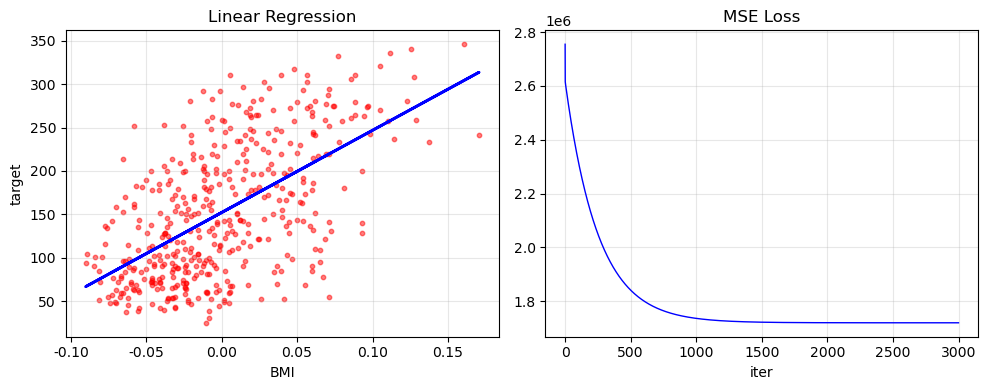

In [5]:
fig, axes = plt.subplots(1, 2)
axes[0].scatter(x, y, c='r', s=10, alpha=0.5)
axes[0].plot(x, X @ w, 'b-', lw=2)
axes[0].set_title('Linear Regression'); axes[0].set_xlabel('BMI'); axes[0].set_ylabel('target'); axes[0].grid(alpha=0.3)
axes[1].plot(loss_hist, 'b-', lw=1)
axes[1].set_title('MSE Loss'); axes[1].set_xlabel('iter'); axes[1].grid(alpha=0.3)
plt.tight_layout(); plt.show()

---
# 2. Perceptron

$$\sigma(z) = \begin{cases} 1 & z \geq 0 \\ 0 & z < 0 \end{cases}, \qquad \mathbf{w} \leftarrow \mathbf{w} + \rho\, \mathbf{X}^T(\mathbf{y} - \sigma(\mathbf{z}))$$

### 데이터 로드

In [6]:
# sklearn Iris 데이터셋 (2 classes, 2 features)
iris = datasets.load_iris()
mask = iris.target < 2                       # class 0, 1만 사용
X_raw = iris.data[mask, :2]                  # sepal length, sepal width
y_cls = iris.target[mask]                    # 0 or 1

# Augmented matrix: [1, x1, x2]
X_cls = np.column_stack([np.ones(len(y_cls)), X_raw])

print(f"X shape: {X_cls.shape}, classes: {np.unique(y_cls)}")

X shape: (100, 3), classes: [0 1]


### 학습 파라미터

In [7]:
step = lambda z: (z >= 0).astype(int)

w = np.zeros(3)
rho = 0.1
n_epochs = 100

### 학습

In [8]:
mis_hist = []

for ep in range(n_epochs):
    y_hat = step(X_cls @ w)
    err = y_cls - y_hat
    mis_hist.append(np.sum(err != 0))
    w = w + rho * (X_cls.T @ err)
    if mis_hist[-1] == 0:
        break

print(f"Converged at epoch {len(mis_hist)}, w = {np.round(w, 3)}")

Converged at epoch 100, w = [ -11.1    63.84 -109.16]


### 시각화

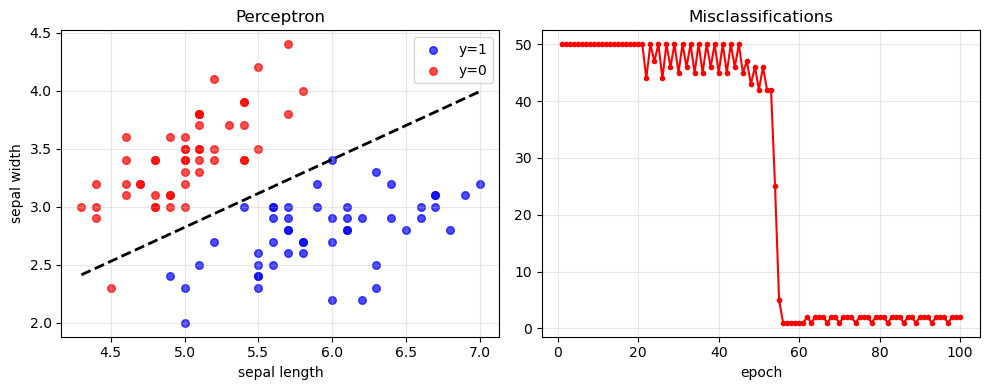

In [9]:
fig, axes = plt.subplots(1, 2)
pos, neg = y_cls==1, y_cls==0
axes[0].scatter(X_raw[pos,0], X_raw[pos,1], c='b', s=30, label='y=1', alpha=0.7)
axes[0].scatter(X_raw[neg,0], X_raw[neg,1], c='r', s=30, label='y=0', alpha=0.7)
x1_line = np.linspace(X_raw[:,0].min(), X_raw[:,0].max(), 100)
x2_line = -(w[0] + w[1]*x1_line) / w[2]
axes[0].plot(x1_line, x2_line, 'k--', lw=2)
axes[0].set_title('Perceptron'); axes[0].set_xlabel('sepal length'); axes[0].set_ylabel('sepal width')
axes[0].legend(); axes[0].grid(alpha=0.3)
axes[1].plot(range(1, len(mis_hist)+1), mis_hist, 'ro-', ms=3)
axes[1].set_title('Misclassifications'); axes[1].set_xlabel('epoch'); axes[1].grid(alpha=0.3)
plt.tight_layout(); plt.show()

---
# 3. Logistic Regression (Binary)

$$\sigma(z) = \frac{1}{1+e^{-z}}, \qquad J = -\sum_n \bigl[ y_n \log \sigma(z_n) + (1-y_n) \log(1-\sigma(z_n)) \bigr]$$

$$\frac{\partial J}{\partial \mathbf{w}} = \mathbf{X}^T(\sigma(\mathbf{z}) - \mathbf{y}), \qquad \mathbf{w} \leftarrow \mathbf{w} - \rho \frac{\partial J}{\partial \mathbf{w}}$$

### 데이터 로드

In [10]:
# Iris 동일 데이터 사용 (위 Section 2와 같음)
print(f"X shape: {X_cls.shape}, classes: {np.unique(y_cls)}")

X shape: (100, 3), classes: [0 1]


### 학습 파라미터

In [11]:
sigmoid = lambda z: 1 / (1 + np.exp(-np.clip(z, -500, 500)))

w = np.zeros(3)
rho = 0.01
n_epochs = 200

### 학습

In [12]:
loss_hist = []

for ep in range(n_epochs):
    o = sigmoid(X_cls @ w)
    loss = -np.sum(y_cls * np.log(o+1e-15) + (1-y_cls) * np.log(1-o+1e-15))
    loss_hist.append(loss)
    grad = X_cls.T @ (o - y_cls)
    w = w - rho * grad

print(f"w = {np.round(w, 3)}")
print(f"Loss: {loss_hist[0]:.2f} → {loss_hist[-1]:.2f}")

w = [ -1.317   6.146 -10.333]
Loss: 69.31 → 4.96


### 시각화

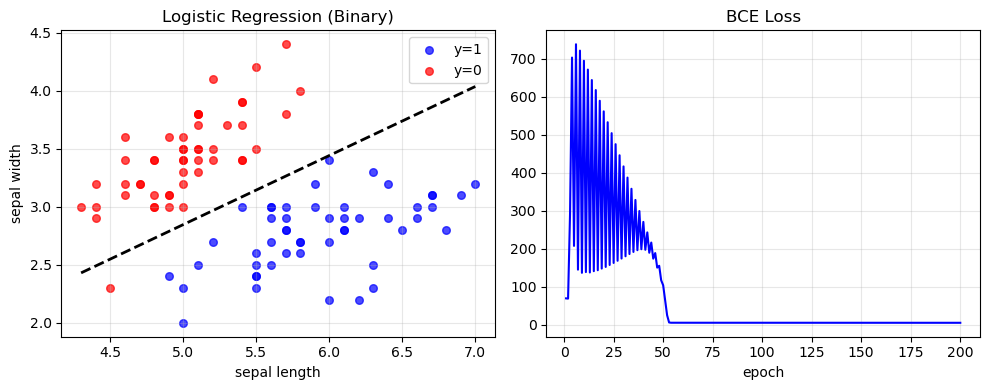

In [13]:
fig, axes = plt.subplots(1, 2)
axes[0].scatter(X_raw[pos,0], X_raw[pos,1], c='b', s=30, label='y=1', alpha=0.7)
axes[0].scatter(X_raw[neg,0], X_raw[neg,1], c='r', s=30, label='y=0', alpha=0.7)
x1_line = np.linspace(X_raw[:,0].min(), X_raw[:,0].max(), 100)
x2_line = -(w[0] + w[1]*x1_line) / w[2]
axes[0].plot(x1_line, x2_line, 'k--', lw=2)
axes[0].set_title('Logistic Regression (Binary)'); axes[0].set_xlabel('sepal length'); axes[0].set_ylabel('sepal width')
axes[0].legend(); axes[0].grid(alpha=0.3)
axes[1].plot(range(1, n_epochs+1), loss_hist, 'b-', lw=1.5)
axes[1].set_title('BCE Loss'); axes[1].set_xlabel('epoch'); axes[1].grid(alpha=0.3)
plt.tight_layout(); plt.show()

---
# 4. Logistic Regression (Multi-class)

$$o_k = \frac{e^{z_k}}{\sum_q e^{z_q}}, \qquad J = -\sum_n \log o_{n,\, y_n}$$

$$\frac{\partial J}{\partial \mathbf{W}} = (\mathbf{O} - \mathbf{Y})^T \mathbf{X}, \qquad \mathbf{W} \leftarrow \mathbf{W} - \rho \frac{\partial J}{\partial \mathbf{W}}$$

### 데이터 로드

In [14]:
# sklearn Iris 전체 (3 classes, 4 features)
iris = datasets.load_iris()
X_raw_mc = iris.data                  # (150, 4)
y_mc = iris.target                    # 0, 1, 2
N, C, d = len(y_mc), 3, 4

# Augmented matrix
X_mc = np.column_stack([np.ones(N), X_raw_mc])   # (150, 5)

# One-hot encoding
Y_oh = np.zeros((N, C))
Y_oh[np.arange(N), y_mc] = 1

print(f"X shape: {X_mc.shape}, classes: {np.unique(y_mc)}, N: {N}")

X shape: (150, 5), classes: [0 1 2], N: 150


### 학습 파라미터

In [15]:
def softmax(z):
    e = np.exp(z - z.max(axis=-1, keepdims=True))
    return e / e.sum(axis=-1, keepdims=True)

W = np.zeros((C, d+1))   # (3, 5)
rho = 0.001
n_epochs = 300

### 학습

In [16]:
loss_hist, acc_hist = [], []

for ep in range(n_epochs):
    O = softmax(X_mc @ W.T)                                        # (N, C)
    loss = -np.sum(np.log(O[np.arange(N), y_mc] + 1e-15))
    acc  = np.mean(np.argmax(O, axis=1) == y_mc)
    loss_hist.append(loss)
    acc_hist.append(acc)
    dW = (O - Y_oh).T @ X_mc                                      # (C, d+1)
    W  = W - rho * dW

print(f"Loss: {loss_hist[0]:.2f} → {loss_hist[-1]:.2f}")
print(f"Accuracy: {acc_hist[0]:.1%} → {acc_hist[-1]:.1%}")

Loss: 164.79 → 23.49
Accuracy: 33.3% → 98.0%


### 시각화

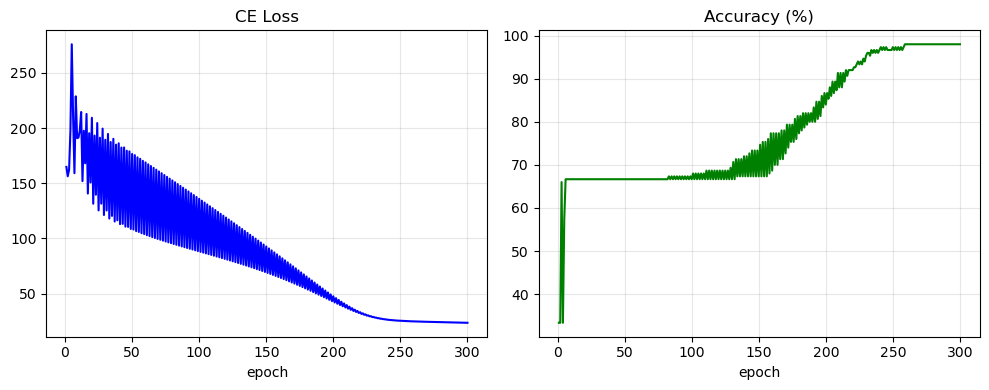

In [17]:
fig, axes = plt.subplots(1, 2)

axes[0].plot(range(1, n_epochs+1), loss_hist, "b-", lw=1.5)
axes[0].set_title("CE Loss"); axes[0].set_xlabel("epoch"); axes[0].grid(alpha=0.3)

axes[1].plot(range(1, n_epochs+1), [a*100 for a in acc_hist], "g-", lw=1.5)
axes[1].set_title("Accuracy (%)"); axes[1].set_xlabel("epoch"); axes[1].grid(alpha=0.3)

plt.tight_layout(); plt.show()

---
# 5. 비교 요약

| | Linear Regression | Perceptron | Logistic (Binary) | Logistic (Multi) |
|---|---|---|---|---|
| **Activation** | identity | step | $\sigma(z)=\frac{1}{1+e^{-z}}$ | softmax |
| **Loss** | $\|\mathbf{Xw}-\mathbf{y}\|^2$ | miscount | $-\sum y\log\sigma$ | $-\sum \log o_{y_n}$ |
| **Gradient** | $2\mathbf{X}^T(\mathbf{Xw}-\mathbf{y})$ | $-\mathbf{X}^T(\mathbf{y}-\hat{\mathbf{y}})$ | $\mathbf{X}^T(\sigma-\mathbf{y})$ | $(\mathbf{O}-\mathbf{Y})^T\mathbf{X}$ |
| **Output** | $\mathbb{R}$ | $\{0,1\}$ | $(0,1)$ | $(0,1)^C$ |
| **Dataset** | Diabetes | Iris (2-class) | Iris (2-class) | Iris (3-class, 4 features) |